In [1]:
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


In [2]:

# Load image and mask
image_bgr = cv2.imread('../../data/imgs/0618.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask = cv2.imread('../../data/imgs/mask0618.png', cv2.IMREAD_GRAYSCALE)

# Set binary labels for mask (1 for road, 0 for non-road)
Y = mask.flatten()
Y = np.where(Y > 128, 1, 0)

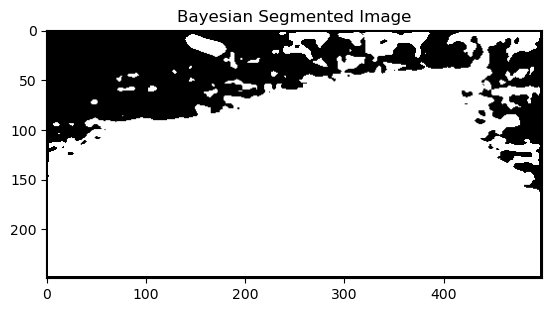

In [3]:

# Define parameters for foreground (road) and background (non-road) based on prior knowledge or statistics
foreground_params = {
    'mean_rgb': np.array([150, 150, 150]),
    'std_rgb': np.array([20, 20, 20]),
    'mean_hsv': np.array([90, 60, 60]),
    'std_hsv': np.array([15, 15, 15]),
    'mean_lab': np.array([145, 128, 128]),
    'std_lab': np.array([10, 10, 10])
}

background_params = {
    'mean_rgb': np.array([60, 60, 60]),
    'std_rgb': np.array([10, 10, 10]),
    'mean_hsv': np.array([0, 0, 50]),
    'std_hsv': np.array([10, 10, 10]),
    'mean_lab': np.array([80, 128, 128]),
    'std_lab': np.array([10, 10, 10])
}


# Function to calculate probability for each color channel in a block given the mean and std deviation
# Function to calculate probability for each color channel in a block given the mean and std deviation
def calculate_probability(block, mean, std):
    # Convert mean and std to numpy arrays to avoid issues with sequence multiplication
    mean = np.array(mean)
    std = np.array(std)
    
    # Calculate the Gaussian probability for each channel in the block
    prob_rgb = np.exp(-0.5 * ((block - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    return np.prod(prob_rgb)  # Use np.prod to multiply across RGB channels


# Bayesian segmentation function
def bayesian_segment(image, fg_params, bg_params, block_size=5):
    height, width, _ = image.shape
    segmented_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(0, height - block_size + 1):
        for j in range(0, width - block_size + 1):
            # Extract block
            block = image[i:i + block_size, j:j + block_size]

            # Compute mean and variance of RGB, HSV, and LAB for the block
            mean_rgb = np.mean(block, axis=(0, 1))
            var_rgb = np.var(block, axis=(0, 1))
            mean_hsv = np.mean(cv2.cvtColor(block, cv2.COLOR_RGB2HSV), axis=(0, 1))
            var_hsv = np.var(cv2.cvtColor(block, cv2.COLOR_RGB2HSV), axis=(0, 1))
            mean_lab = np.mean(cv2.cvtColor(block, cv2.COLOR_RGB2LAB), axis=(0, 1))
            var_lab = np.var(cv2.cvtColor(block, cv2.COLOR_RGB2LAB), axis=(0, 1))

            # Calculate probability for foreground
            p_fg_rgb = calculate_probability(mean_rgb, fg_params['mean_rgb'], fg_params['std_rgb'])
            p_fg_hsv = calculate_probability(mean_hsv, fg_params['mean_hsv'], fg_params['std_hsv'])
            p_fg_lab = calculate_probability(mean_lab, fg_params['mean_lab'], fg_params['std_lab'])
            p_fg = p_fg_rgb * p_fg_hsv * p_fg_lab

            # Calculate probability for background
            p_bg_rgb = calculate_probability(mean_rgb, bg_params['mean_rgb'], bg_params['std_rgb'])
            p_bg_hsv = calculate_probability(mean_hsv, bg_params['mean_hsv'], bg_params['std_hsv'])
            p_bg_lab = calculate_probability(mean_lab, bg_params['mean_lab'], bg_params['std_lab'])
            p_bg = p_bg_rgb * p_bg_hsv * p_bg_lab

            # Decide class based on maximum posterior probability
            label = 1 if p_fg > p_bg else 0
            segmented_image[i + block_size // 2, j + block_size // 2] = label * 255

    return segmented_image


# Segment the image using the Bayesian approach
segmented_image = bayesian_segment(image_rgb, foreground_params, background_params)

# Display segmented image
plt.imshow(segmented_image, cmap='gray')
plt.title("Bayesian Segmented Image")
plt.show()


# Post-process the segmented image
def post_process(segmented_image, kernel_size=3, min_area=100):
    # Morphological operations to clean up segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    opened = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

    # Connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed, connectivity=8)
    processed_image = np.zeros_like(segmented_image, dtype=np.uint8)

    # Retain large connected components
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            processed_image[labels == i] = 255

    return processed_image


# Apply post-processing
processed_segmented_image = post_process(segmented_image)


Accuracy: 0.844296
Precision: 0.7909099737787705
Recall: 0.9988280504755934
Confusion Matrix:
 [[32241 19377]
 [   86 73296]]


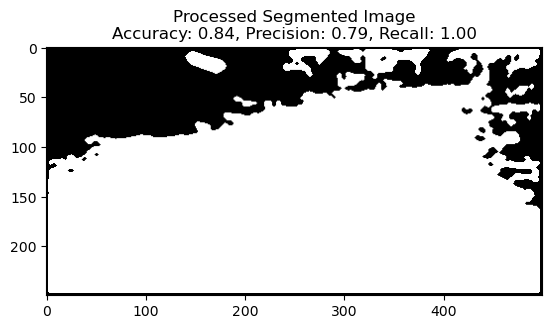

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Flatten the ground truth and predicted images for evaluation
ground_truth = mask.flatten() // 255  # Assuming mask is in 0 and 255, convert to 0 and 1
predicted = processed_segmented_image.flatten() // 255  # Assuming segmented result is also in 0 and 255

# Calculate accuracy, precision, recall, and confusion matrix
accuracy = accuracy_score(ground_truth, predicted)
precision = precision_score(ground_truth, predicted)
recall = recall_score(ground_truth, predicted)
conf_matrix = confusion_matrix(ground_truth, predicted)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

# Display metrics
plt.imshow(processed_segmented_image, cmap='gray')
plt.title(f"Processed Segmented Image\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()
